<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Ali Nazari
### Student Number : 99102401
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [3]:
transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.1307],std=[0.3081])])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [4]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [5]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=16)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [6]:
class ResidualClassifier(nn.Module):
    def __init__(self):
        super(ResidualClassifier, self).__init__()
        self.network1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding='same'), nn.ReLU(), nn.BatchNorm2d(16), nn.MaxPool2d(2, 2))
        self.network2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'), nn.ReLU(), nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'), nn.ReLU(), nn.BatchNorm2d(16))
        self.network3 = nn.Sequential(nn.MaxPool2d(2, 2), nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding='same'), nn.ReLU(), nn.BatchNorm2d(64))
        self.network4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'), nn.ReLU(), nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'), nn.ReLU(), nn.BatchNorm2d(64))
        self.network5 = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(64, 10))
    def forward(self, x):
        x = self.network1(x)
        x = x + self.network2(x)
        x = self.network3(x)
        x = x + self.network4(x)
        return self.network5(x)

# Train Model (30 Points)

In [7]:
model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
# I used https://jovian.com/aakashns/05b-cifar10-resnet alot for this section
total_step = len(train_loader)
num_epochs = 20
loss_plot = list()
acc_plot = list()
loss_plot_2 = list()
acc_plot_2 = list()

for epoch in range(num_epochs):
    loss_sum = 0
    true_predicted = 0
    total_number = 0
    for images, labels in train_loader:
        total_number += labels.size(0)
        images = images.to(device)
        labels = labels.to(device)
        model_output = model(images)
        _, each_row_max = torch.max(model_output, 1)
        true_predicted += (each_row_max == labels).sum().item()
        optimizer.zero_grad()
        loss = criterion(model_output, labels)
        loss.backward()
        loss_sum += loss.item()
        optimizer.step()
    loss_plot.append(loss_sum/total_number)
    acc_plot.append(true_predicted/total_number)
    print(f'TRAIN - epoch: {epoch + 1}, accuracy {acc_plot[-1]}')

    loss_sum = 0
    true_predicted = 0
    total_number = 0
    with torch.no_grad():
        for images, labels in val_loader:
            total_number += labels.size(0)
            images = images.to(device)
            labels = labels.to(device)
            model_output = model(images)
            _, each_row_max = torch.max(model_output, 1)
            true_predicted += (each_row_max == labels).sum().item()
            loss = criterion(model_output, labels)
            loss_sum += loss.item()
    loss_plot_2.append(loss_sum/total_number)
    acc_plot_2.append(true_predicted/total_number)
    print(f'VALIDATION - epoch: {epoch + 1}, accuracy {acc_plot_2[-1]}')

TRAIN - epoch: 1, accuracy 0.95874
VALIDATION - epoch: 1, accuracy 0.9824
TRAIN - epoch: 2, accuracy 0.98214
VALIDATION - epoch: 2, accuracy 0.9829
TRAIN - epoch: 3, accuracy 0.9863
VALIDATION - epoch: 3, accuracy 0.9879
TRAIN - epoch: 4, accuracy 0.98862
VALIDATION - epoch: 4, accuracy 0.9858
TRAIN - epoch: 5, accuracy 0.99018
VALIDATION - epoch: 5, accuracy 0.9856
TRAIN - epoch: 6, accuracy 0.99162
VALIDATION - epoch: 6, accuracy 0.9907
TRAIN - epoch: 7, accuracy 0.99316
VALIDATION - epoch: 7, accuracy 0.9892
TRAIN - epoch: 8, accuracy 0.99372
VALIDATION - epoch: 8, accuracy 0.9886
TRAIN - epoch: 9, accuracy 0.99414
VALIDATION - epoch: 9, accuracy 0.9901
TRAIN - epoch: 10, accuracy 0.99442
VALIDATION - epoch: 10, accuracy 0.9904
TRAIN - epoch: 11, accuracy 0.99594
VALIDATION - epoch: 11, accuracy 0.9898
TRAIN - epoch: 12, accuracy 0.99552
VALIDATION - epoch: 12, accuracy 0.9914
TRAIN - epoch: 13, accuracy 0.99616
VALIDATION - epoch: 13, accuracy 0.9909
TRAIN - epoch: 14, accuracy 0.9

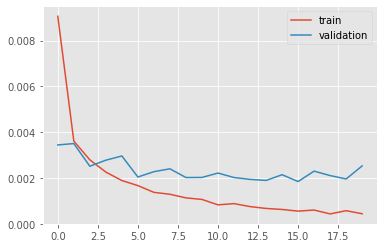

In [9]:
plt.plot(loss_plot, label='train')
plt.plot(loss_plot_2, label='validation')
plt.legend()

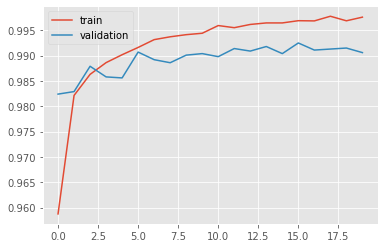

In [10]:
plt.plot(acc_plot, label='train')
plt.plot(acc_plot_2, label='validation')
plt.legend()

# Test Model (20 Points)

10000
acc 0.9941


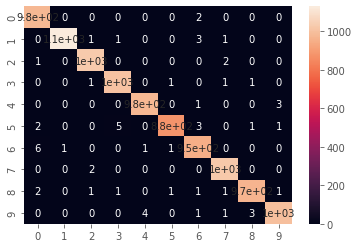

In [11]:
test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))

true_predicted = 0
total_number = 0
real_labels = list()
predicted_labels = list()

with torch.no_grad():
    for images, labels in test_loader:
        real_labels += labels.cpu().tolist()
        total_number += labels.size(0)
        images = images.to(device)
        labels = labels.to(device)
        model_output = model(images)
        _, each_row_max = torch.max(model_output, 1)
        predicted_labels += each_row_max.cpu().tolist()
        true_predicted += (each_row_max == labels).sum().item()
print('acc ' + str(true_predicted / total_number))

matrix = confusion_matrix(real_labels, predicted_labels)
sns.heatmap(matrix, annot=True)